### =======================================================================================
# DataVidia 7.0 - Analisis Sentimen dengan Text Mining 
### =======================================================================================
Mas William merupakan manager perusahaan jaringan operator mitra hotel ternama di Indonesia. Dalam pekerjaan sehari - harinya, mas William sering kali perlu menangani masalah - masalah yang ada pada jasa perhotelan yang diberikan perusahaan. Namun, belakangan ini aplikasinya sangat sering dipakai sehingga mas William kewalahan untuk menemukan mana review buruk yang perlu penanganan segera. Akibatnya, mas William dimarahi oleh bos Jopan. Mas William pun pergi menemui mas Yoga, seorang data scientist handal di perusahaan tersebut untuk menemukan solusinya. Mas Yoga menawarkan untuk membantu mas William dapat bekerja dengan lebih efisien. Bantulah Mas Yoga untuk melakukan prediksi apakah suatu review termasuk review positif atau negatif.
## =======================================================================

# 1. Preprocessing

## 1.1 Import Libraries & Functions

In [ ]:
# Importing necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
factory = StemmerFactory()

     |████████████████████████████████| 215kB 5.3MB/s 


In [ ]:
# Function : Remove irrelevant words
def replace_substring(old_words,new_word,string) :
    """
    Fungsi untuk mengganti substring didalam suatu string dengan
    syarat string tersebut sudah di ubah dalam format list terlebih
    dahulu.
    old_words = harus dalam format list
    new_word = single word only
    string = list of substring
    Returns
    -------
    string
    """
    for kata in old_words :
        string = [word.replace(kata,new_word) if word == kata else word for word in string]
    return string

## 1.2 Import Datasets

In [ ]:
# Import Datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [ ]:
stopwords = pd.read_fwf('stopword.txt')
stopwords = list(stopwords['stopword'])
stopwords.append("nya")

In [ ]:
# Show train data
train.sample(5)

,review_id,review_text,category
2696,cffc589628305bbd81bd7076ec11dfea,menurut saya orang yang berkacamata dan agak g...,0
1666,262109a9927b927a616c680c8f99fdaa,susah mencari alamatnya,0
11607,0f01e8f29a58c094a71b0a0b10d99835,"kamar mandi kurang bersih karena ada kecoa, sa...",0
913,d7de3b777272f049a22f2d66992abefa,Waktu datang bagian resevasi...tidak ada ditem...,0
2941,4c2e03557c7477e8e43198e35311f1bb,"cemilan yg d sediakan kurang, air mineral boto...",0


In [ ]:
# Show test data
test.sample(5)

,review_id,review_text
2209,e6e4fe418a698f34ca3c052889031db3,pelayanan tidak ramah ; petugas sibuk main hp;...
2588,451ad463586599db6e653f3cb1bcb64e,kotor. tak terawat. terutama kmr mandi
1430,970033c9447cdfd2f9fab6985584e553,"kurang bersih, tidak nyaman dan tidak tenang"
170,97505af8644e22617a589c87d41d5495,"VERY BAD NOT RECOMENDED, TIDAK ADA AIR PANAS ..."
678,46392f5cc402708a702d1c95c16d5f32,Jelek bgt. Kotor. Gak bisa ganti handuk atau s...


In [ ]:
# Show sample data
sample.sample(5)

,review_id,category
3420,550bb06104fff163a3341f0b2a74fbe2,0
2268,7052163b72d128b430ff889c15470b3d,0
973,d6db44fbcfaae09a75c3a168d59729b3,0
3009,baab024fbae6fc9812ecd1eb2641aa69,0
3668,d4da22eabcc2abc11be1b15017f1f38b,0


In [ ]:
# Show size of data
train.shape, test.shape, sample.shape

((14856, 3), (3714, 2), (3714, 2))

In [ ]:
train_len = len(train) # Save length of train data

In [ ]:
# Check missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

In [ ]:
# Concatenate train & test data
df = train.append(test).reset_index(drop=True)
df.shape

(18570, 3)

## 1.3 Data Visualization on train data

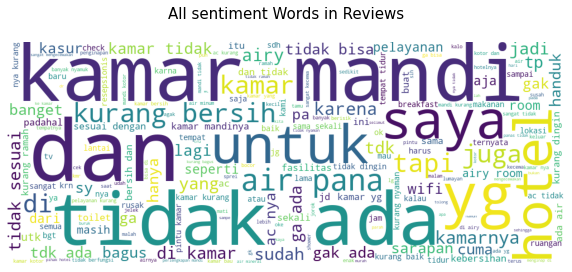

In [ ]:
# All Reviews (positive & negative)
from wordcloud import WordCloud
alls = train['review_text']
positive = train[train.category == 1].review_text
negative = train[train.category == 0].review_text
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate(" ".join(alls))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('All sentiment Words in Reviews\n',size=15)
plt.axis('off')
plt.show()

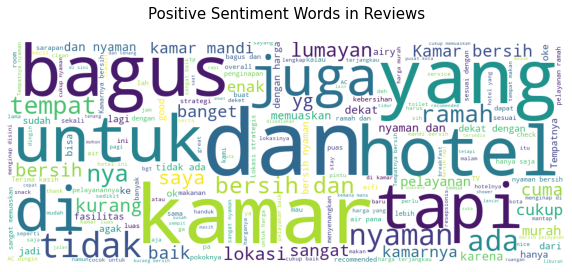

In [ ]:
# Positive reviews
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate(" ".join(positive))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('Positive Sentiment Words in Reviews\n',size=15)
plt.axis('off')
plt.show()

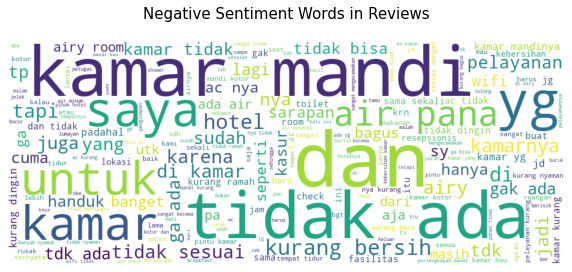

In [ ]:
# Negative reviews
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate(" ".join(negative))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('Negative Sentiment Words in Reviews\n',size=15)
plt.axis('off')
plt.show()

In [ ]:
# Visualize length of review
train['len_text'] = train.review_text.apply(lambda x : len(x))
df['len_text'] = df.review_text.apply(lambda x : len(x))
train.head(8)

,review_id,review_text,category,len_text
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1,194
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0,159
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0,227
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0,59
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,10
5,a45d79bde831ad1306adbd8ffb5d3d50,"kebersihan, pelayanan, kerapihan",0,32
6,ecdf90bd55184829caae18e5423a2e53,saya hampir tidak bisa tidur krn bantal sangat...,0,55
7,b0a8cb904f0536dca57bd5be090e510c,"Pelayanannya sangat baik,kmr yang bersih,menu ...",1,99


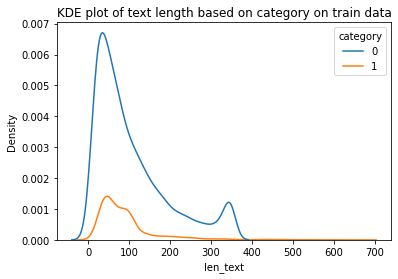

In [ ]:
sns.kdeplot(x='len_text', data=train, hue='category')
plt.title("KDE plot of text length based on category on train data")
plt.show()

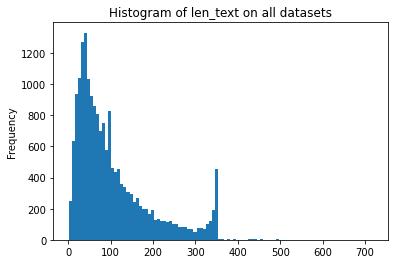

In [ ]:
df.len_text.plot(kind='hist',bins=100)
plt.title("Histogram of len_text on all datasets")
plt.show()

## 1.4 Cleaning Text

In [ ]:
# List of "kata tidak baku"
tidaks = ["gak","gk","ga","tdk","ngk","nggak", "engga","tidaj","gaak"
          "ngga","ngak","g","ng","tak","ndk","ndak","enggak"
          "blm","belum","tdak","tida", "gada","gag","gda","tidk"]
baguss = ['oke','ok','bgs','okey','oklah','bagusa','mantap',
          'okee', 'cakep']
kurangs = ['kurng','krg','dikit']
bangets = ['banget','bngt','bgt','terlalu','sekali','sgt','bangeet','sangat'] 
lumayans = ["lmyn","cukup","ckp","mayan"]
lambats = ["lemot","lelet","lamban","lmbn","lambn",'lmban','ngadat']
iyas = ["ya","y","iyya","yaa"]
ajas = ["doank","doang", "ajaa"]
dengans = ["dgn","dg"]
kamars = ['kamr','kmr','kmar','romm','rom']
bauks = ['bauk','bauu', 'pesing', 'apek'] 
bobroks = ['ancur','hancur', 'ancuran', 'ancurn']
sulits = ['ribet','rumit','susah','ruwet']
jijiks = ["amit","jijik","ilfeel"]
berisiks = ["bising","brisik","berisiik",'berderinyit']
recoms = ['reccomended', 'rekomended', 'remomended', 'recomend', 
          'recomended','rekomendet', 'rekomend', 'rekomended', 
          'rekomen', 'recomen' ]
cumas = ['cm','cmn','cuma','cuman']
robeks =['koyak', 'bolong' ]
putuss =['copot', 'pataahh']
kecewas =['kecewaa', 'capek']
mudahs =['gampang']
sempits =['sumpek', 'pengap', 'gempil', 'mampet', 'keciiillll']
lembabs =['becek']
jeleks =['juelek']
kuats =['kenceng']
burams= ['burem']

In [ ]:
# Replace "kata tidak baku" dengan "kata baku"
strings = []
for i in range(0, len(df)) :
    string = re.sub('[^a-zA-Z]',' ',df['review_text'][i])
    string = string.lower()
    string = string.replace("x", "nya")
    string = string.split()
    # Replace substring
    string = replace_substring(robeks,"robek", string)
    string = replace_substring(putuss,"putus", string)
    string = replace_substring(kecewas,"kecewa", string)
    string = replace_substring(mudahs,"mudah", string)
    string = replace_substring(sempits,"sempit", string)
    string = replace_substring(lembabs,"lembab", string)
    string = replace_substring(jeleks,"jelek", string)
    string = replace_substring(kuats,"kuat", string)
    string = replace_substring(burams,"buram", string)
    string = replace_substring(cumas,"cuma", string)
    string = replace_substring(tidaks, "tidak", string)
    string = replace_substring(baguss, "bagus", string)
    string = replace_substring(kurangs, "kurang", string)
    string = replace_substring(bangets, "sangat", string)
    string = replace_substring(lumayans, "lumayan", string)
    string = replace_substring(iyas, "iya", string)
    string = replace_substring(ajas, "saja", string)
    string = replace_substring(lambats, "lambat", string)
    string = replace_substring(dengans, "dengan", string)
    string = replace_substring(kamars, "kamar", string)
    string = replace_substring(bauks, "bau", string)
    string = replace_substring(bobroks, "bobrok", string)
    string = replace_substring(sulits, "sulit", string)
    string = replace_substring(jijiks, "jijik", string)
    string = replace_substring(berisiks, "berisik", string)
    string = replace_substring(recoms, "recommended", string)
    string = replace_substring(["ad"], "ada", string)
    string = replace_substring(["nyesel"], "menyesal", string)
    string = replace_substring(["enk"], "enak", string)
    string = replace_substring(["cek","chek"], "check", string)
    string = replace_substring(["sereem", "seremm", "seraam","serem"], "seram", string)
    string = replace_substring(['jutek' 'kecuutt', 'cuek', 'judes', 'jengkel'], "tidak ramah", string)
    string = replace_substring(['udh','sdh','udah','sdah'], "sudah", string)
    string = replace_substring(["kumuh","dekil","ktr","jorok", "buluk", "kumal"], "kotor", string)
    string = replace_substring(["krn","karna"], "karena", string)
    string = replace_substring(['pening','mumet'], "pusing", string)
    string = replace_substring(['mampet'], "mampat", string)
    string = replace_substring(['eror'], "error", string)
    string = replace_substring(['skali'], "sekali", string)
    string = replace_substring(['dn','ama', 'n'], "dan", string)
    string = replace_substring(['tp','tpi','tetapi'], "tapi", string)
    string = replace_substring(['gatel'], "gatal", string)
    string = replace_substring(['ilang'], "hilang", string)
    string = replace_substring(['boking'], "booking", string)
    string = replace_substring(['kran'], "keran", string)
    string = replace_substring(['tdr','tdur'], "tidur", string)
    string = replace_substring(['bs','bsa'], "bisa", string)
    # Remove substring yg tidak ada huruf vokal
    for word in string :
        if ((bool(re.findall('a|i|u|e|o', word)) == False) & (len(word) >= 1) & (word != "tv")) :
            string.remove(word)
    string = [word for word in string if not word in stopwords]
    string = ' '.join(string)
    strings.append(string)

In [ ]:
strings

['penginapannya rapi bersih suasana tenang pelayannya ramah membantu lokasi lumayan obyek wisata bandung menginap',
 'wifi tidak kamar tidak tersedia heater kopi teh dispenser tidak tersedia kursi kamar merokok duduk lantai',
 'lantai kamar mandi kotor bau jdi sarang nyamuk dikamar mandinya pesan superior double dikasih twin murah maklumin kedepan mohon jdi perbaikan baik',
 'kotor kasur tidak dibersihkan handuk tidak diganti',
 'bocor',
 'kebersihan pelayanan kerapihan',
 'tidak tidur bantal bau bau',
 'pelayanannya baik kamar bersih menu makanannya enak to sayang wifinya kutang bagus',
 'kamar kecoa diperhatikan kebersihannya',
 'kamar mandi banjir',
 'menjaga kebersihan tidur kenyamanan tamu bebial bial betiga beranak tilamnya hibak pempijit sarang pempijit dikepala ranjangnya untungnya pindah kamar',
 'pelayanan kurang ramah sulit administrasi tidak recommended nginap dsini',
 'hotel bersih nyaman kolam renang bersih pelayanan hotel baik deket indomaret hotel makanan manado murah e

In [ ]:
# Stemming string with sastrawi
corpus = []
stemmer = factory.create_stemmer()
for string in strings :
    string = string.split()
    string = [stemmer.stem(word) for word in string]
    string = ' '.join(string)
    corpus.append(string)   

# 2. EDA

## 2.1 Target Distributions

In [ ]:
train['sentiment'] = train.category.apply(lambda x : 'positive' if x == 1 else 'negative')
train["sentiment"].value_counts(normalize = True)

negative    0.86423
positive    0.13577
Name: sentiment, dtype: float64

Dataset kita memberi informasi bahwa 86% berisi komentar negatif. Informasi ini akan sangat berguna untuk bagian pemodelan.

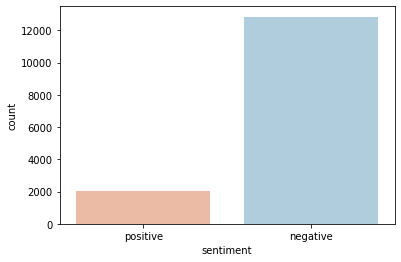

In [ ]:
sns.countplot(x='sentiment', data=train, palette='RdBu')
plt.xlabel('sentiment')
plt.show()

In [ ]:
# Create new dataset contains clean strings
train_clean = strings[:train_len]
test_clean = strings[train_len:]
target = train.category.values
train_clean = pd.DataFrame({"review_text":train_clean, "category":target})
test_clean = pd.DataFrame({"review_id":test.review_id.values,"review_text":test_clean})
df_clean = train_clean.append(test_clean).reset_index(drop=True)

## 2.2 Show data distributions

### 2.2.1 Reviews based on category

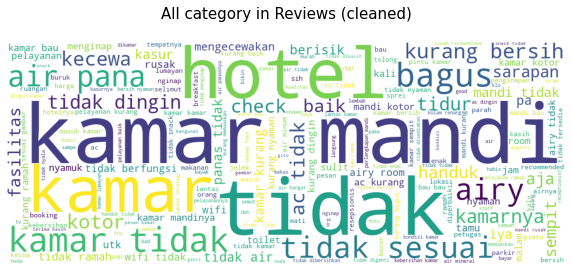

In [ ]:
# All Reviews (positive & negative) cleaned
alls_clean = train_clean['review_text']
positive_clean = train_clean[train_clean.category == 1].review_text
negative_clean = train_clean[train_clean.category == 0].review_text
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate(" ".join(alls_clean))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('All category in Reviews (cleaned)\n',size=15)
plt.axis('off')
plt.show()

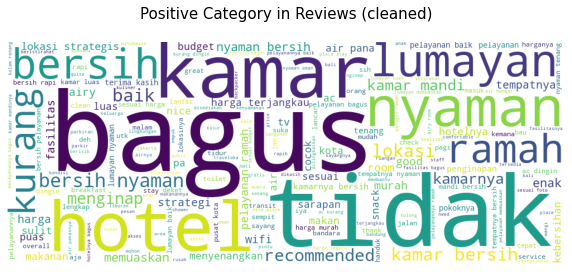

In [ ]:
# Positive reviews (cleaned)
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate(" ".join(positive_clean))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('Positive Category in Reviews (cleaned)\n',size=15)
plt.axis('off')
plt.show()

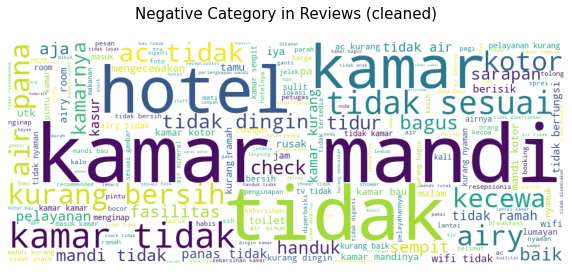

In [ ]:
# Negative reviews (cleaned)
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate(" ".join(negative_clean))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('Negative Category in Reviews (cleaned)\n',size=15)
plt.axis('off')
plt.show()

### 2.2.2 Sentiment Words

In [ ]:
positif = ['easy', 'fresh', 'free', 'worth', 'recommended','nice','great', 
             'near','complimentary', 'save', 'good','mudah', 'seru', 'lumayan', 
             'aktif','menarik', 'menyenangkan', 'terjangkau','komplit', 'sopan', 
             'terawat', 'asik', 'murah', 'licin', 'strategis', 'lengkap','kencang', 
             'luas', 'enak', 'membantu', 'hemat', 'segar', 'berfungsi', 'istimewa', 
             'terawat', 'memudahkan', 'tersedia', 'memuaskan', 'enak','sehat','memadai',
             'disediakan',  'strategis','dikasih',  'sopan','tanggap', 'ramah','rapih',
             'nyaman','keren', 'ramah', 'bagus', 'cepat', 'murah', 'ramah', 'senang', 'aman',
             'sesuai', 'enak']
negatif = ['jijik', 'rusak', 'takut', 'jarang', 'mengganggu', 'menjijikan', 
           'sinis', 'mengganggu', 'jarang', 'arogan', 'gelap', 'usang', 'lusuh', 
           'aneh', 'sulit', 'menyedihkan',  'mahal', 'teguran', 'suram', 'cerewet',
           'angker', 'berkarat', 'posesif', 'mati','debu', 'gatal', 'dirugikan', 
           'jelek', 'berdengung', 'jarang','telat', 'ribut', 'ribet', 'tersumbat',
           'kecoa', 'lusuh','kecewa',  'jarang','sempit', 'menakutkan', 'terkelupas',
           'tutup','tipis','pusing', 'buram', 'berminyak', 'perbaikan', 'jorok', 
           'susah', 'lambat', 'seram', 'sepi', 'dibawah', 'error', 'kesalahan', 
           'sulit', 'berkarat', 'buruk',  'jarang', 'busuk','berbahaya', 
           'mengecewakan', 'susah', 'komplain','macet','mengganggu','minim',
           'lambat', 'keras', 'bau', 'jorok', 'putus', 'kusam', 'gelap', 
           'patah','jutek','risih','minus','sempit', 'capek','bermasalah',
           'bocor', 'becek', 'menengecewakan','menyebalkan', 'lengket', 
           'komplain', 'diperbaiki', 'sempit', 'rusak', 'kumuh', 'lambat', 'kecewa',
           'kotor', 'tertipu', 'berdebu', 'bau','tingkatkan', 'susah', 'berisik',
           'lembab', 'usang', 'rusak', 'panas', 'jelek', 'kuning', 'asin', 'noda' ,
           'rambut','lambat', 'jamur','bercak','unsatisfaction', 'smells', 'spooky', 'dark', 'gloomy', 
           'cancel', 'steepi','slippery', 'damp', 'moldy', 'reeked', 'melepuh', 'musibah', 'galak', 'sakit', 
           'trauma','mohon', 'usang', 'teriak', 'terpaksa', 'cancel', 'worst', 'careless', 'bad']

In [ ]:
# Visualize of Positive Sentiment words
diz = {}
for string in list(train_clean.review_text) :
    string = string.split()
    for word in string:
        if word in positif:
            diz[word] = diz.get(word,0)+1

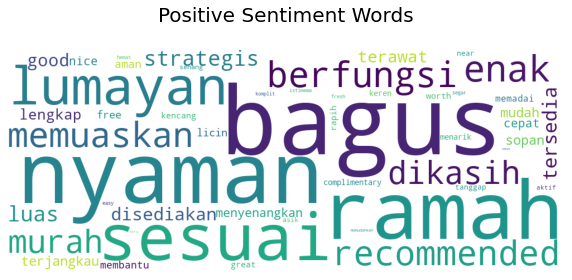

In [ ]:
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate_from_frequencies(diz)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('Positive Sentiment Words\n',size=20)
plt.axis('off')
plt.show()

In [ ]:
# Visualize of Negative Sentiment words
diz = {}
for string in list(train_clean.review_text) :
    string = string.split()
    for word in string:
        if word in negatif:
            diz[word] = diz.get(word,0)+1

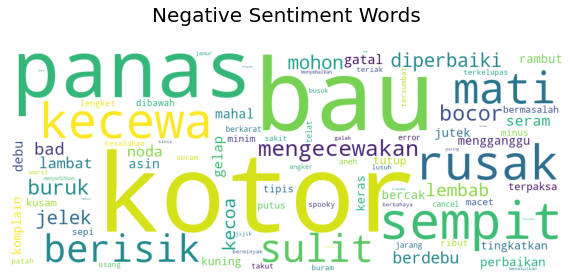

In [ ]:
wordcloud = WordCloud(background_color='white',
                      width=1000,
                      height=400
                     ).generate_from_frequencies(diz)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('Negative Sentiment Words\n',size=20)
plt.axis('off')
plt.show()

### 2.2.3 Checking Missing values

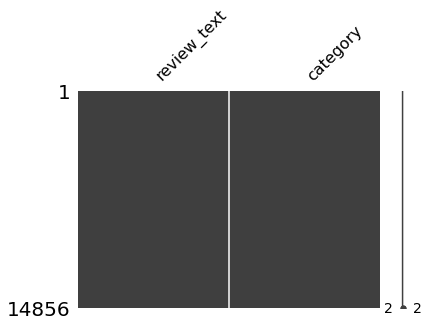

In [ ]:
import missingno
missingno.matrix(train_clean, figsize=(6,4))
plt.show()

### 2.2.4 Show histogram of length string

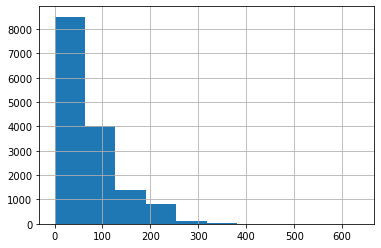

In [ ]:
train_clean['review_text'].str.len().hist()

In [ ]:
train_clean['len_text'] = train_clean.review_text.apply(lambda x : len(x))

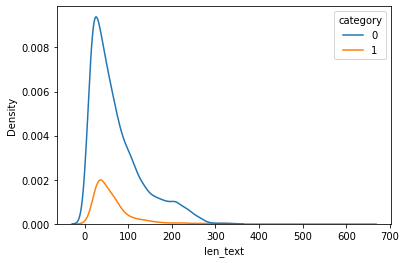

In [ ]:
sns.kdeplot(x='len_text', data=train_clean, hue='category')

# 3. Feature Engineering

## 3.1 Bag of Words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df.review_text).toarray()

In [ ]:
X.shape

(18570, 10569)

In [ ]:
cols_num = X.shape[1]
cols_num

10569

## 3.2 Apply Bag of Words to Datasets

In [ ]:
#Dataset dalam format array
train_data = X[:train_len]
test_data = X[train_len:]
train_data.shape, target.shape, test_data.shape

((14856, 10569), (14856,), (3714, 10569))

In [ ]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [ ]:
train_df.isnull().sum().any(), test_df.isnull().sum().any()

(False, False)

In [ ]:
test_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10529,10530,10531,10532,10533,10534,10535,10536,10537,10538,10539,10540,10541,10542,10543,10544,10545,10546,10547,10548,10549,10550,10551,10552,10553,10554,10555,10556,10557,10558,10559,10560,10561,10562,10563,10564,10565,10566,10567,10568
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 3.3 Data Distribution

0 column


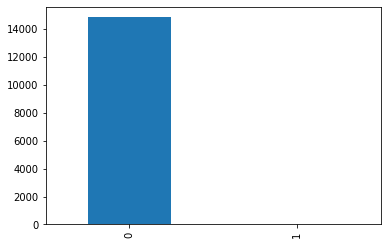

1 column


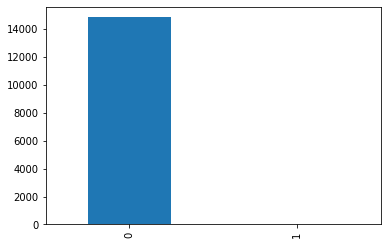

2 column


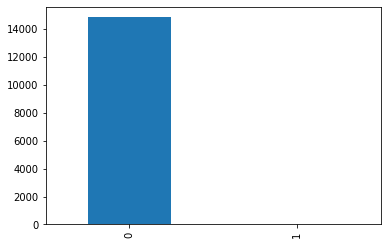

3 column


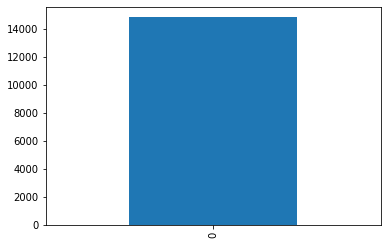

4 column


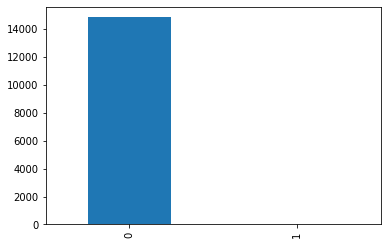

5 column


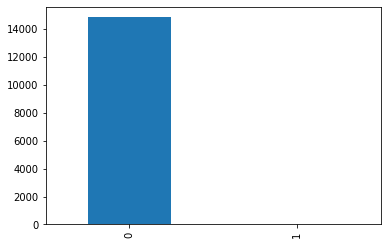

6 column


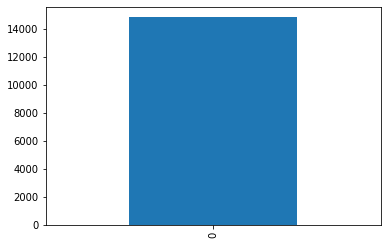

7 column


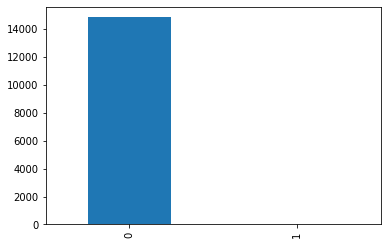

8 column


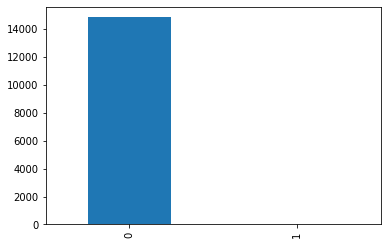

9 column


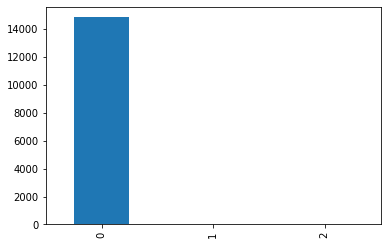

10 column


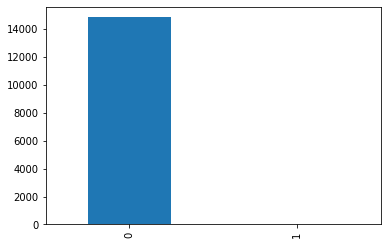

11 column


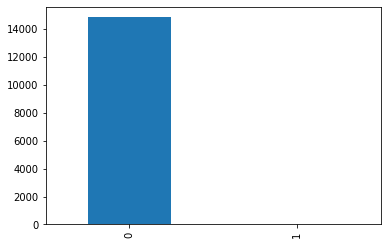

12 column


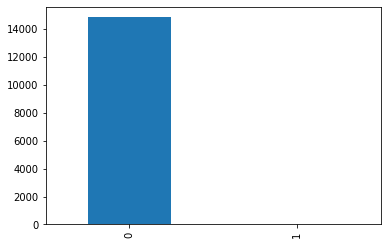

13 column


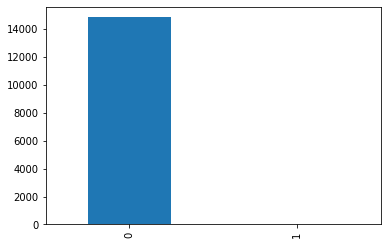

14 column


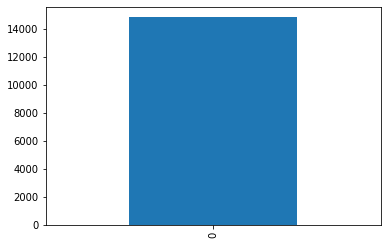

15 column


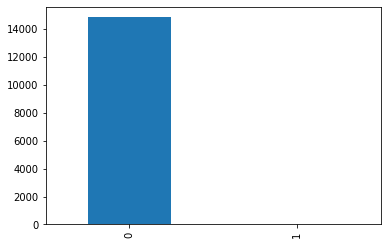

16 column


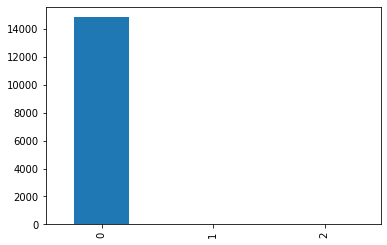

17 column


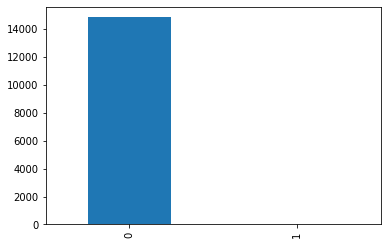

18 column


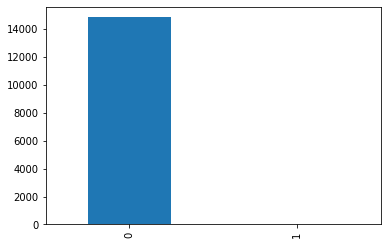

19 column


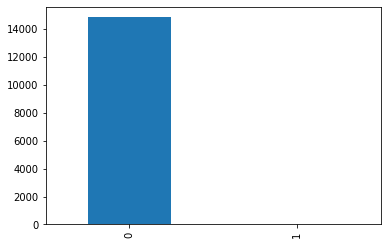

In [ ]:
for i in range(0,20) :
    print("{} column".format(i))
    train_df[i].value_counts().plot(kind='bar')
    plt.show()

## 3.4 Analysis of Variance

In [ ]:
# train data
index = []
variances = []
for i in range(0, cols_num) :
    var = train_df[i].var()
    variances.append(var)
    index.append(i)
train_vardf = pd.DataFrame({"index":index, "variance":variances})
train_vardf.variance.max(), train_vardf.variance.min()

(1.133400428700179, 0.0)

In [ ]:
# test data
index = []
variances = []
for i in range(0, cols_num) :
    var = test_df[i].var()
    variances.append(var)
    index.append(i)
test_vardf = pd.DataFrame({"index":index, "variance":variances})
test_vardf.variance.max(), test_vardf.variance.min()

(1.108375207631152, 0.0)

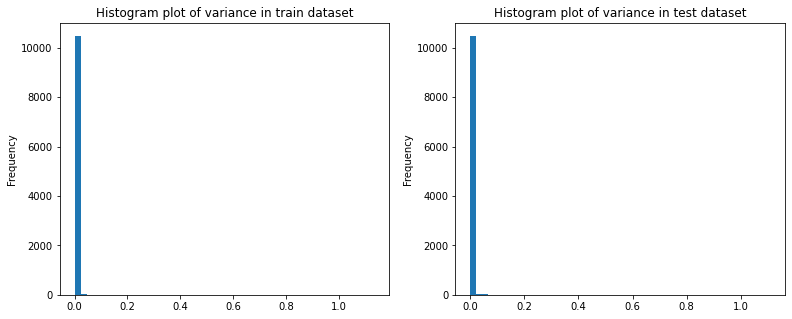

In [ ]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
train_vardf.variance.plot(kind='hist', bins=50)
plt.title("Histogram plot of variance in train dataset")

plt.subplot(1,2,2)
test_vardf.variance.plot(kind='hist', bins=50)
plt.title("Histogram plot of variance in test dataset")
plt.show()

In [ ]:
# Extract the index where variance is 0.0 in train data
cnt_train = []
for i in range(0,cols_num) :
    if train_df[i].nunique() == 1 :
        cnt_train.append(i)
len(cnt_train)

1282

In [ ]:
cnt_train

[3,
 6,
 14,
 25,
 36,
 39,
 45,
 51,
 61,
 67,
 74,
 94,
 108,
 119,
 125,
 129,
 138,
 142,
 148,
 158,
 167,
 171,
 172,
 228,
 230,
 235,
 248,
 254,
 257,
 258,
 270,
 279,
 282,
 289,
 291,
 294,
 309,
 313,
 317,
 324,
 331,
 345,
 357,
 378,
 380,
 388,
 398,
 400,
 406,
 408,
 415,
 438,
 445,
 473,
 480,
 485,
 497,
 515,
 527,
 546,
 560,
 562,
 565,
 572,
 589,
 623,
 626,
 634,
 654,
 661,
 678,
 707,
 722,
 723,
 728,
 752,
 753,
 773,
 774,
 793,
 795,
 805,
 811,
 812,
 836,
 853,
 862,
 865,
 892,
 893,
 898,
 909,
 912,
 936,
 940,
 943,
 945,
 948,
 951,
 955,
 960,
 963,
 966,
 967,
 969,
 972,
 991,
 992,
 994,
 996,
 1009,
 1064,
 1067,
 1070,
 1082,
 1091,
 1107,
 1109,
 1133,
 1143,
 1146,
 1153,
 1167,
 1179,
 1180,
 1189,
 1194,
 1204,
 1206,
 1215,
 1219,
 1230,
 1231,
 1238,
 1241,
 1242,
 1260,
 1271,
 1280,
 1287,
 1292,
 1316,
 1323,
 1329,
 1339,
 1346,
 1353,
 1371,
 1378,
 1387,
 1397,
 1410,
 1421,
 1474,
 1479,
 1488,
 1498,
 1551,
 1559,
 1565,
 156

Dataset dengan indeks cnt_train akan dibuang dari dataset karena ragamnya bernilai 0.0

In [ ]:
# Remove columns with index from cnt_train
train_df.drop(cnt_train, axis=1, inplace=True)
test_df.drop(cnt_train, axis=1, inplace=True)
train_df.shape, test_df.shape

((14856, 9287), (3714, 9287))

In [ ]:
train_df.isna().sum().any(), test_df.isna().sum().any()

(False, False)

# 4. Modelling

In [ ]:
X = train_df.values
X_test = test_df.values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, target, test_size = 0.3, random_state = 0)

## 4.1 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
logreg = LogisticRegression(random_state = 0, class_weight='weight')
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_val)
score_logreg = f1_score(y_val, y_pred_logreg)
print(score_logreg)

0.7524575513851652


In [ ]:
yhat = logreg.predict(X_test)
sample['category'] = yhat
sample.to_csv('submission_logreg.csv',index=False)

In [ ]:
sample['category'].value_counts()

0    3288
1     426
Name: category, dtype: int64